# Chapter 5

Please note that all of the observations at the beginning of the chapter are derived from Chapters 3, and 4. The code provided here will be used to replicate charts/graphs, and observations not found in other chapters.

## Loading Libraries

In [ ]:
import os
# Change to the directory of the current file
os.chdir(r"D:\MyDrive\10. MS in Data Science UofWisconsin\16. Markowitz Optimization Final Code\CH5")

import sys 
sys.path.append(r"D:\MyDrive\10. MS in Data Science UofWisconsin\16. Markowitz Optimization Final Code\CH5")

# data wrangling libs
import numpy as np 
import pandas as pd 
from siuba import * 
from siuba.dply.vector import *

# random methods
from LopezRandomMethod import random_gen_weights
from randomness_by_RogerStafford import randfixedsum 

# UDF: unit circle df (sine and cosine coordinates), dowloading historical stock prices
from unitCircle import unitCircle as unitCircleDf
from function_filePrep import tickerList, download_data,missing_days_andIndexTimeZone, to_month_and_add_monthYear_columns

# graphing
import matplotlib.pyplot as plt 
from plotnine import * 

# optimization
from scipy.optimize import minimize # SLSQP
from simanneal import Annealer # Annealing
from scipy.optimize import dual_annealing

# shapiro and ranksum
from scipy.stats import shapiro , ranksums

import time  # to time processes 



In [4]:
cambios_dji_hist=dji_pricehist.pct_change().dropna()

## Historical Optimized Weights

In [8]:
from datetime import date, datetime, timedelta
from siuba import *

start_date = date(2023,8,1)
end_date = date(2024,7,31)

def prev_startdate(fn_startDate: date):
    return (fn_startDate - timedelta(days=1)).replace(day=1)
def prev_enddate(fn_endDate:date): 
    return fn_endDate.replace(day=1) - timedelta(days=1)

import yfinance as yf

# Define the ticker symbol for Dow Jones Industrial Average
ticker = '^DJI'

# Download historical data
djia_data = yf.download(ticker, start='2020-01-01', end='2024-08-01')
dji_pricehist=missing_days_andIndexTimeZone(djia_data['Close'])

def fn_get_histPrice(fn_startFecha:date, fn_endFecha:date)->pd.DataFrame:
    #downloading 1 year of data
    df_ticker = download_data(list_stocks=tickerList,start_date = fn_startFecha.strftime('%Y-%m-%d'), end_date = fn_endFecha.strftime('%Y-%m-%d'))
    df_tickerprice1=missing_days_andIndexTimeZone(df_ticker)
    return df_tickerprice1
    ## returns only    
    #training_pct_change=df_tickerprice1.pct_change().dropna()

full_hist_prices=fn_get_histPrice(date(2020,1,1),date(2024,8,1))

def fn_get_DJI_mean_std(fn_prices:pd.DataFrame, start_date:date, end_date:date):
    df_DJI_results=fn_prices.reset_index() >> filter(_.Date >= start_date.strftime('%Y-%m-%d'),_.Date < end_date.strftime('%Y-%m-%d')) >> \
    mutate(price_change = _.Close.pct_change()) >> _.dropna() >> summarize(mean_change_price = _.price_change.mean()*41, 
                                                                           std_price = _.price_change.std()*np.sqrt(41)
                                                                           ) >> mutate(sharpe1 = _.mean_change_price/_.std_price)

    return df_DJI_results.loc[0,'mean_change_price'], df_DJI_results.loc[0,'std_price']
    # pct_change_dji = (fn_prices.apply(lambda x: x/sum(x), axis=1) * fn_prices).sum(axis=1).pct_change().dropna()
    # return pct_change_dji.mean()*41, pct_change_dji.std()*np.sqrt(41)
def fn_getPctChange(fn_prices:pd.DataFrame)->pd.DataFrame: 
    return fn_prices.pct_change().dropna()
def returnDf_results(stDate:date, enDate:date,return_DJI, risk_DJI, return_bestPortfolio, risk_bestPortfolio, best_weights): 
    return pd.DataFrame(
        {
            'startDate': [stDate],
            'endDate': [enDate],
            'DJI_return': [return_DJI],
            'DJI_risk': [risk_DJI],
            'BestPort_return': [return_bestPortfolio],
            'BestPort_risk': [risk_bestPortfolio], 
            'Best_Weights': [best_weights]

        }
    )


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  30 of 30 completed


In [10]:
def portfolio_return(weights, returns):
    return np.dot(weights, returns.mean()) * 41 # times 41 b/c there are 41 trading days in August and Sept

def portfolio_risk(weights, returns):
    cov_matrix = returns.cov() * 41
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights, returns, risk_free_rate=0):
    port_return = portfolio_return(weights, returns)
    port_risk = portfolio_risk(weights, returns)
    #returns negative because we will use scipy.optimize.minimize
    return - (port_return - risk_free_rate) / port_risk

In [14]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = [(0, 1) for _ in range(full_hist_prices.shape[1])]

In [15]:
from siuba import *
startingDf = pd.DataFrame(
        {
            'startDate':[],
            'endDate':[],
            'DJI_return': [],
            'DJI_risk': [],
            'BestPort_return': [],
            'BestPort_risk': [], 
            'Best_Weights': []

        }
    )
start_date = date(2023,8,1)
end_date = date(2024,8,1)
while True: 
    if start_date < date(2020,1,1):
        break 
    else: 
        df_prices_iter=full_hist_prices >> filter(_.index >= start_date.strftime('%Y-%m-%d'), 
                           _.index < end_date.strftime('%Y-%m-%d'))
        
        
        #df_prices_iter=fn_get_histPrice(start_date,end_date)
        dji_mean_iter, dji_risk_iter=fn_get_DJI_mean_std(dji_pricehist, start_date=start_date,end_date=end_date)   
         
        df_returns_iter = fn_getPctChange(df_prices_iter)
        
        result_SLSQP_iter = minimize(sharpe_ratio, np.full(30, 1/30), args=(df_returns_iter,), 
                                     method='SLSQP', 
                                     bounds=bounds, constraints=constraints)
        
        best_weights_iter = result_SLSQP_iter.x 
        bestPort_return_iter=portfolio_return(best_weights_iter,df_returns_iter)
        bestPort_risk_iter=portfolio_risk(best_weights_iter,df_returns_iter)

        df_iter=returnDf_results(start_date, end_date, dji_mean_iter,dji_risk_iter, bestPort_return_iter,bestPort_risk_iter, best_weights_iter )
        startingDf = pd.concat([startingDf,df_iter])

        start_date = prev_startdate(start_date)
        end_date = prev_startdate(end_date)

In [17]:
df_cambiosDePesos=pd.DataFrame(startingDf.Best_Weights.tolist(), index=startingDf['startDate'],columns=full_hist_prices.columns).round(2)

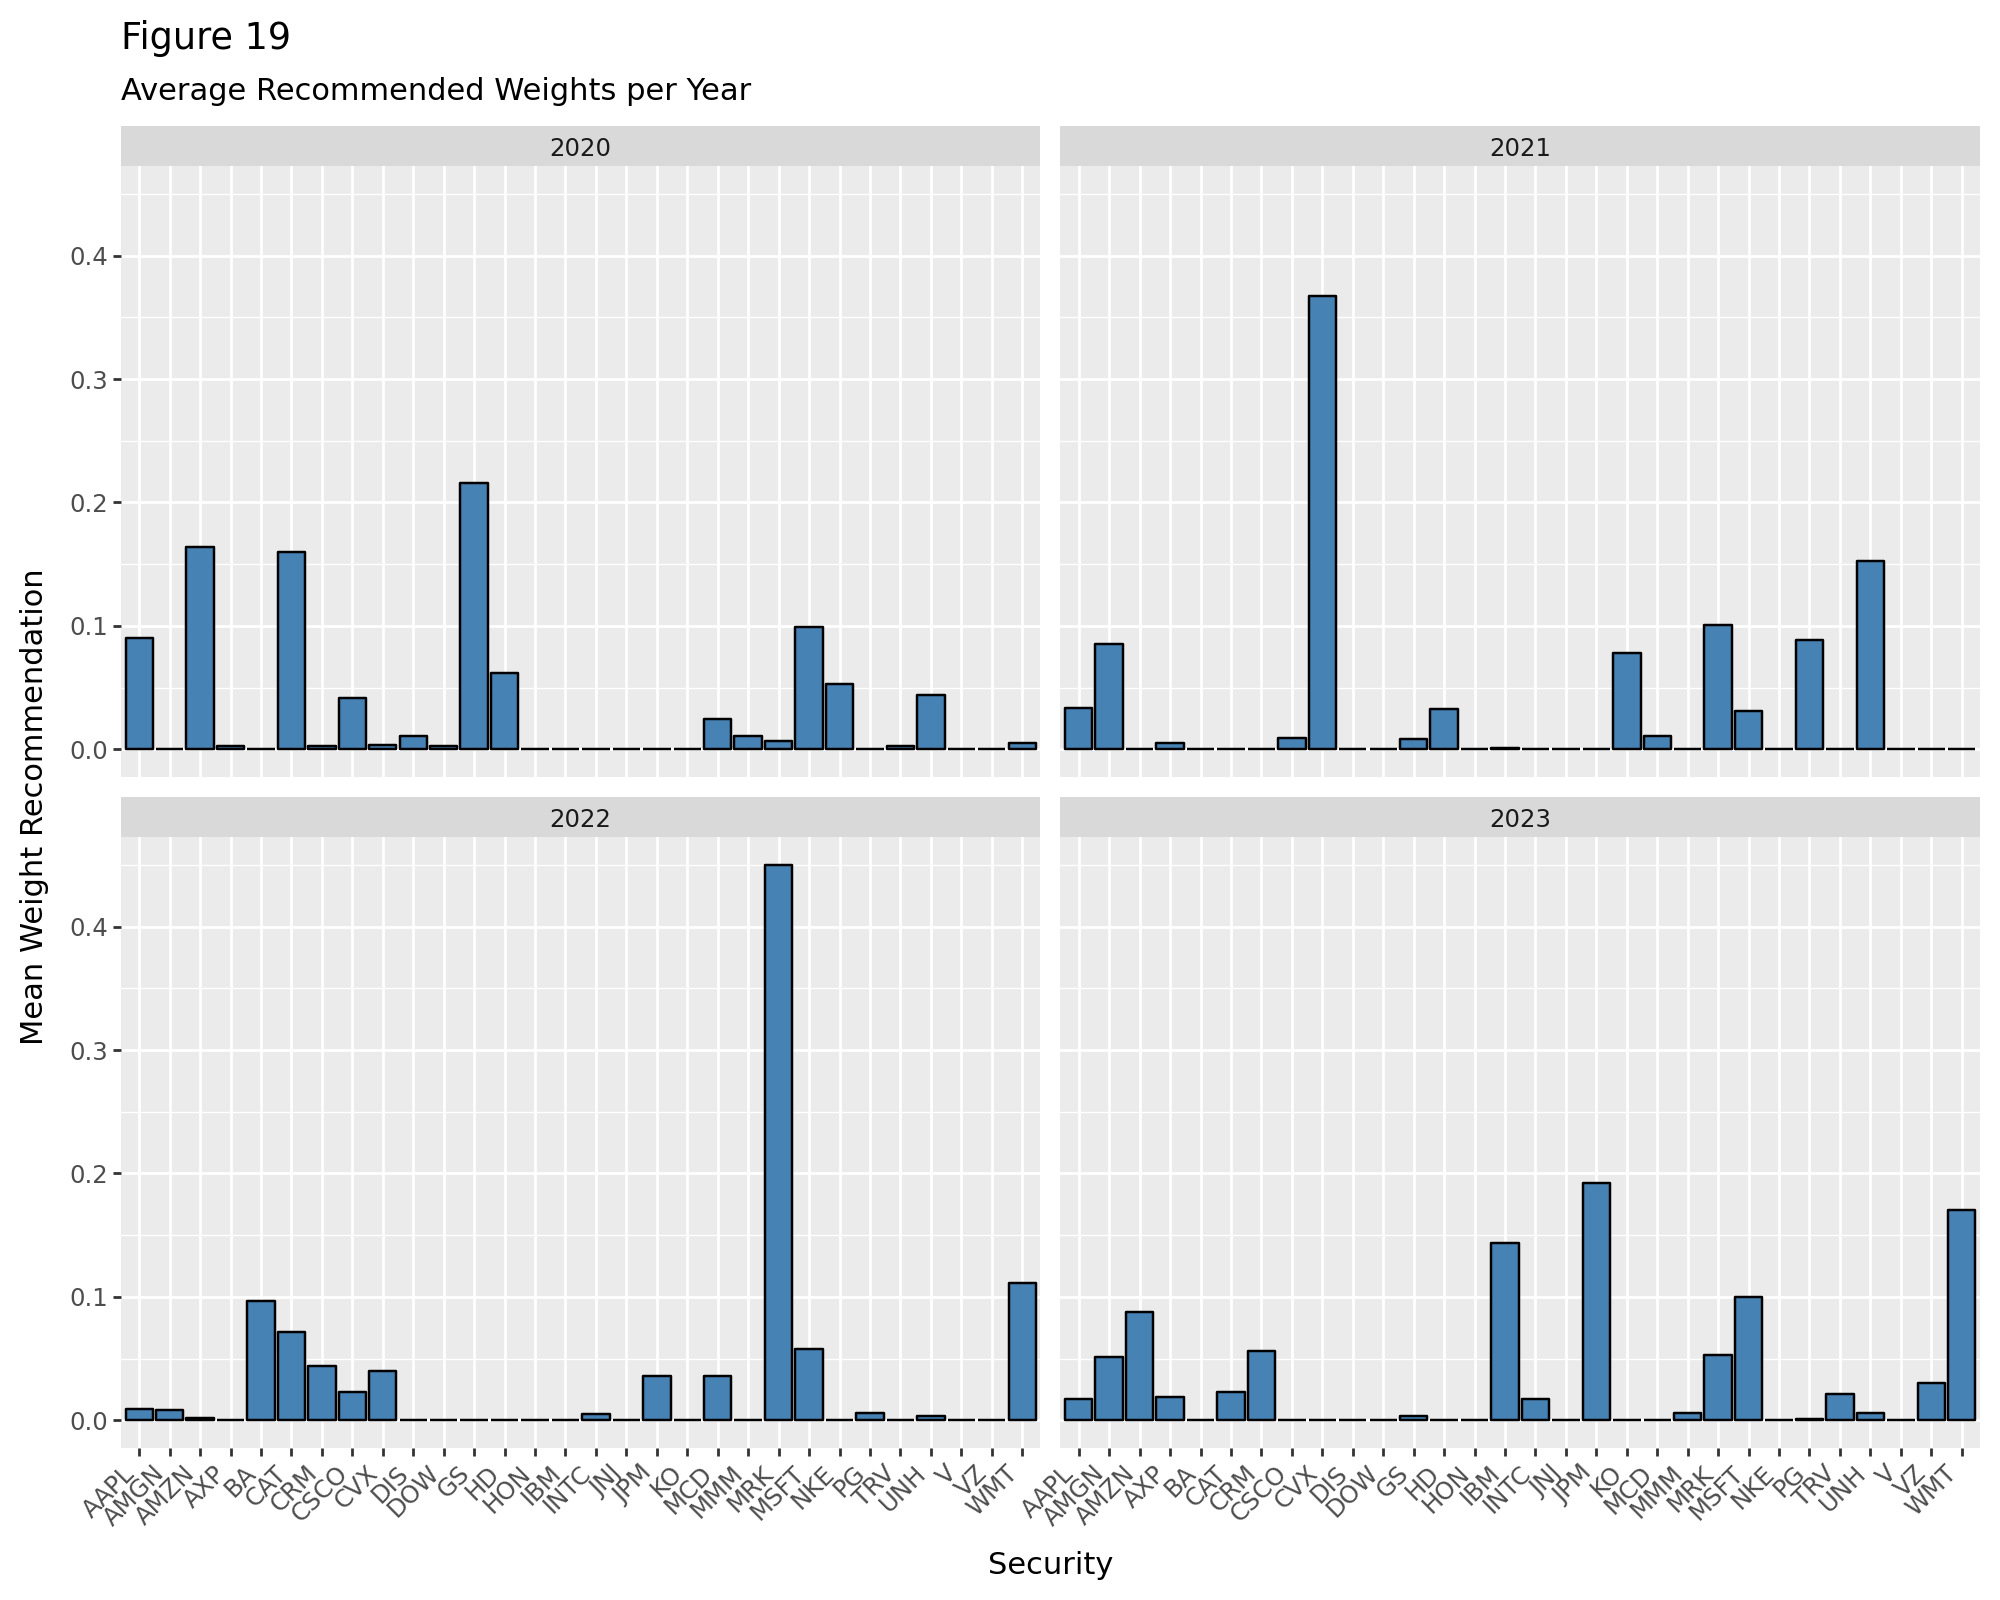

In [23]:
df_cambiosDePesos.reset_index().melt(id_vars='startDate') >> mutate(anho = _.apply(lambda x: x['startDate'].year,axis=1)) >> \
group_by(_.anho, _.variable) >> summarize(promedios_pesos = _.value.mean()) >> \
ggplot() + geom_col(aes(x='variable', y = 'promedios_pesos'), fill='steelblue', color='black') + facet_wrap('~anho') + \
theme(axis_text_x=element_text(angle=45, hjust=1), figure_size=(10,8))+\
labs(y='Mean Weight Recommendation', x = 'Security', title='Figure 19', subtitle='Average Recommended Weights per Year')


## CVX Prices in Time

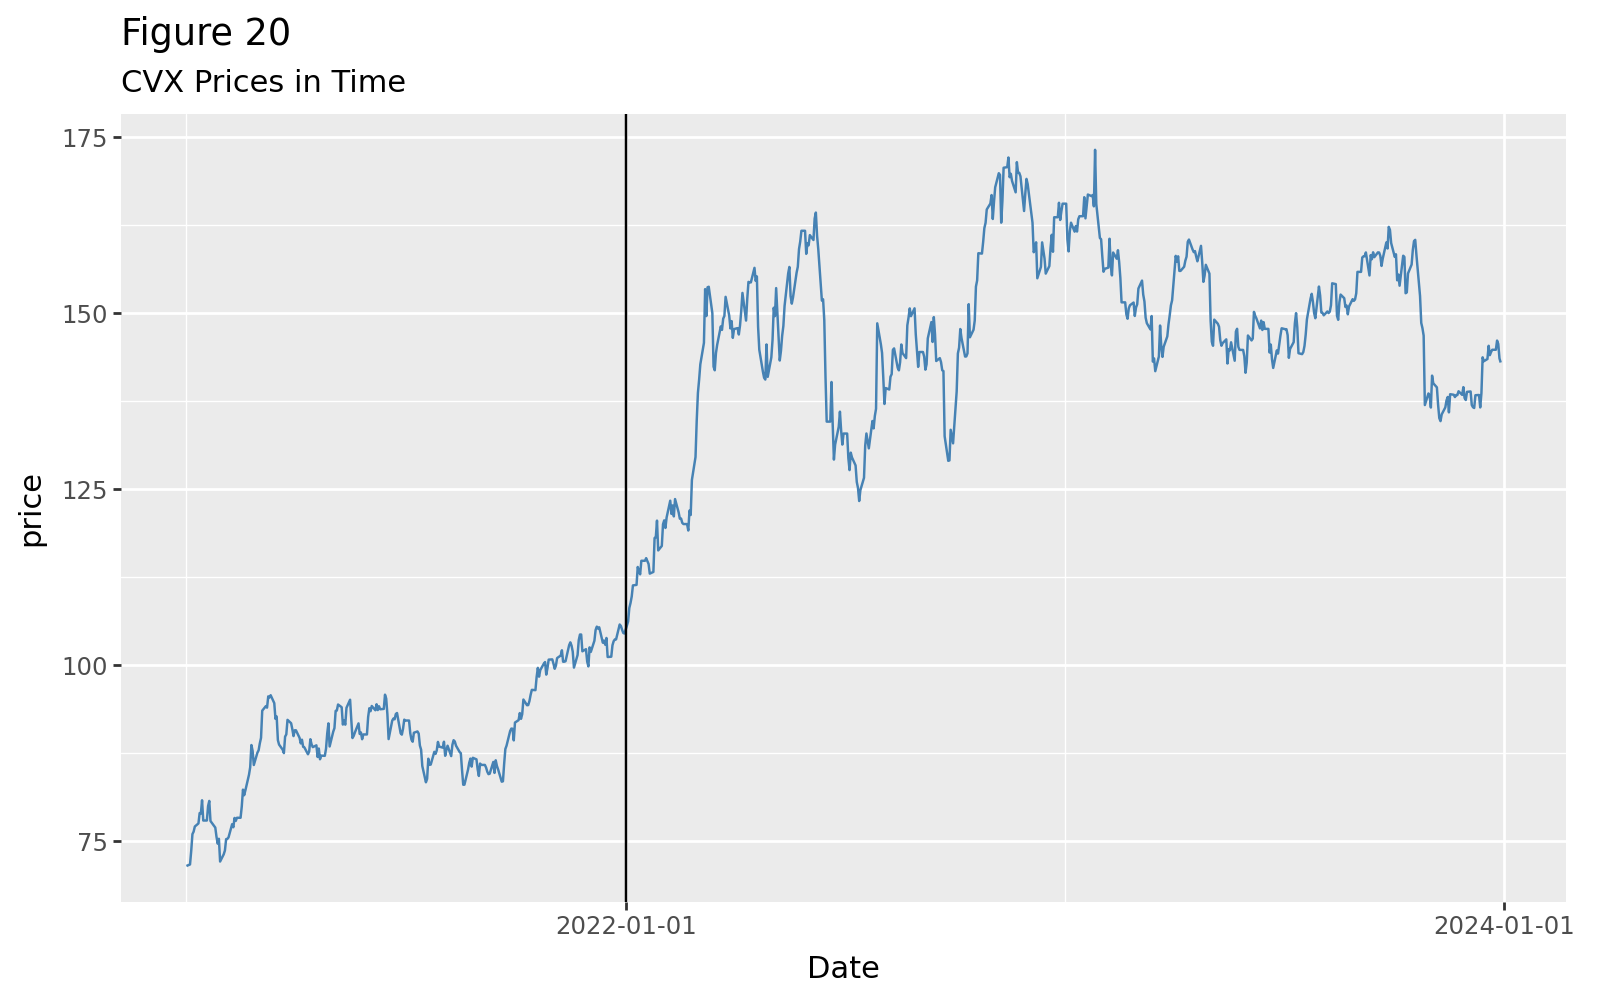

In [35]:
full_hist_prices["2021-01-01":"2023-12-31"].CVX.reset_index() >> ggplot() + geom_line(aes(x='Date',y='CVX'), color='steelblue') + \
labs(y='price', title='Figure 20', subtitle='CVX Prices in Time') + geom_vline(xintercept = '2022-01-01')+ theme(figure_size=(8,5)) 

## Distribution of Returns 

### Histogram of Expected Returns
- This histogram looks at the distribution of daily expected returns for both SLSQP and DJI. 

In [49]:
last12_returns = full_hist_prices >> filter(_.index >= '2023-08-01', _.index<'2024-08-01') >> _.pct_change().dropna()
result_SLSQP_last12months = minimize(sharpe_ratio, 
                                     np.full(30, 1/30), 
                                     args=(last12_returns,), # change depending on time period
                                     method='SLSQP', 
                                     bounds=bounds, 
                                     constraints=constraints)
ret_SLSQP_last12months=last12_returns.dot(result_SLSQP_last12months.x).reset_index().rename(columns = {0:'Pct_Change'}) >> mutate(index='SLSQP')
ret_dji_last12months=cambios_dji_hist.reset_index() >> filter(_.Date>='2023-08-02')>> mutate(index = 'DJI') >> rename(Pct_Change = 'Close')
expected_returns=pd.concat([ret_dji_last12months, ret_SLSQP_last12months]) >> \
    group_by(_.index) >>\
          summarize(ave_return = _.Pct_Change.mean()) >> _.ave_return

exp_ret_DJI,exp_ret_SLSQP =expected_returns[0],expected_returns[1]


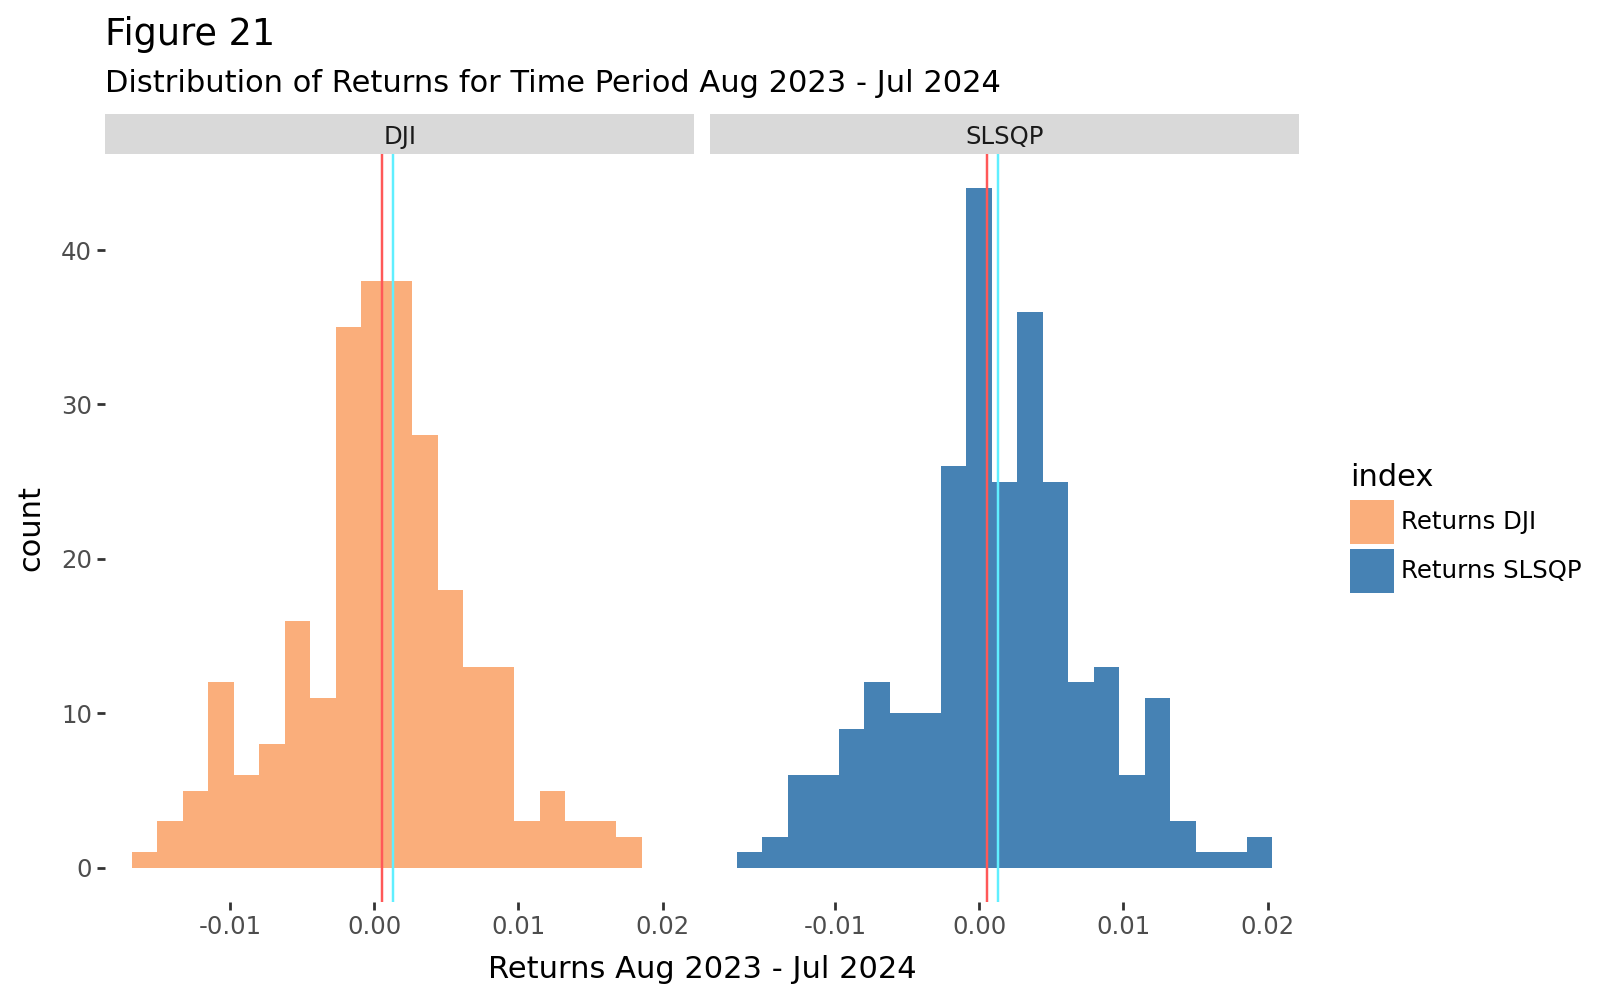

In [50]:
pd.concat([ret_dji_last12months, ret_SLSQP_last12months]) >> arrange(_.Pct_Change) >> ggplot() + \
    geom_histogram(aes(x='Pct_Change', fill = 'index'), position='identity')+facet_wrap('~index')+\
scale_fill_manual(
        values={
            'DJI': '#faae7b',
            'SLSQP': 'steelblue'
        },
        labels={
            'DJI': 'Returns DJI',
            'SLSQP': 'Returns SLSQP'
        }        
    ) +\
geom_vline(xintercept = exp_ret_DJI, color= '#ff5858') + geom_vline(xintercept = exp_ret_SLSQP, color= '#60efff') +\
theme(panel_background= element_rect(fill='white'), figure_size=(8,5)) + labs(x='Returns Aug 2023 - Jul 2024', title='Figure 21',
                                                                              subtitle='Distribution of Returns for Time Period Aug 2023 - Jul 2024')

### Expected Return DJI, and SLSQP

In [ ]:
exp_ret_DJI, exp_ret_SLSQP

(0.0005424259607218472, 0.0012904826999017931)

## Mean Reverting Characteristic

### Graph

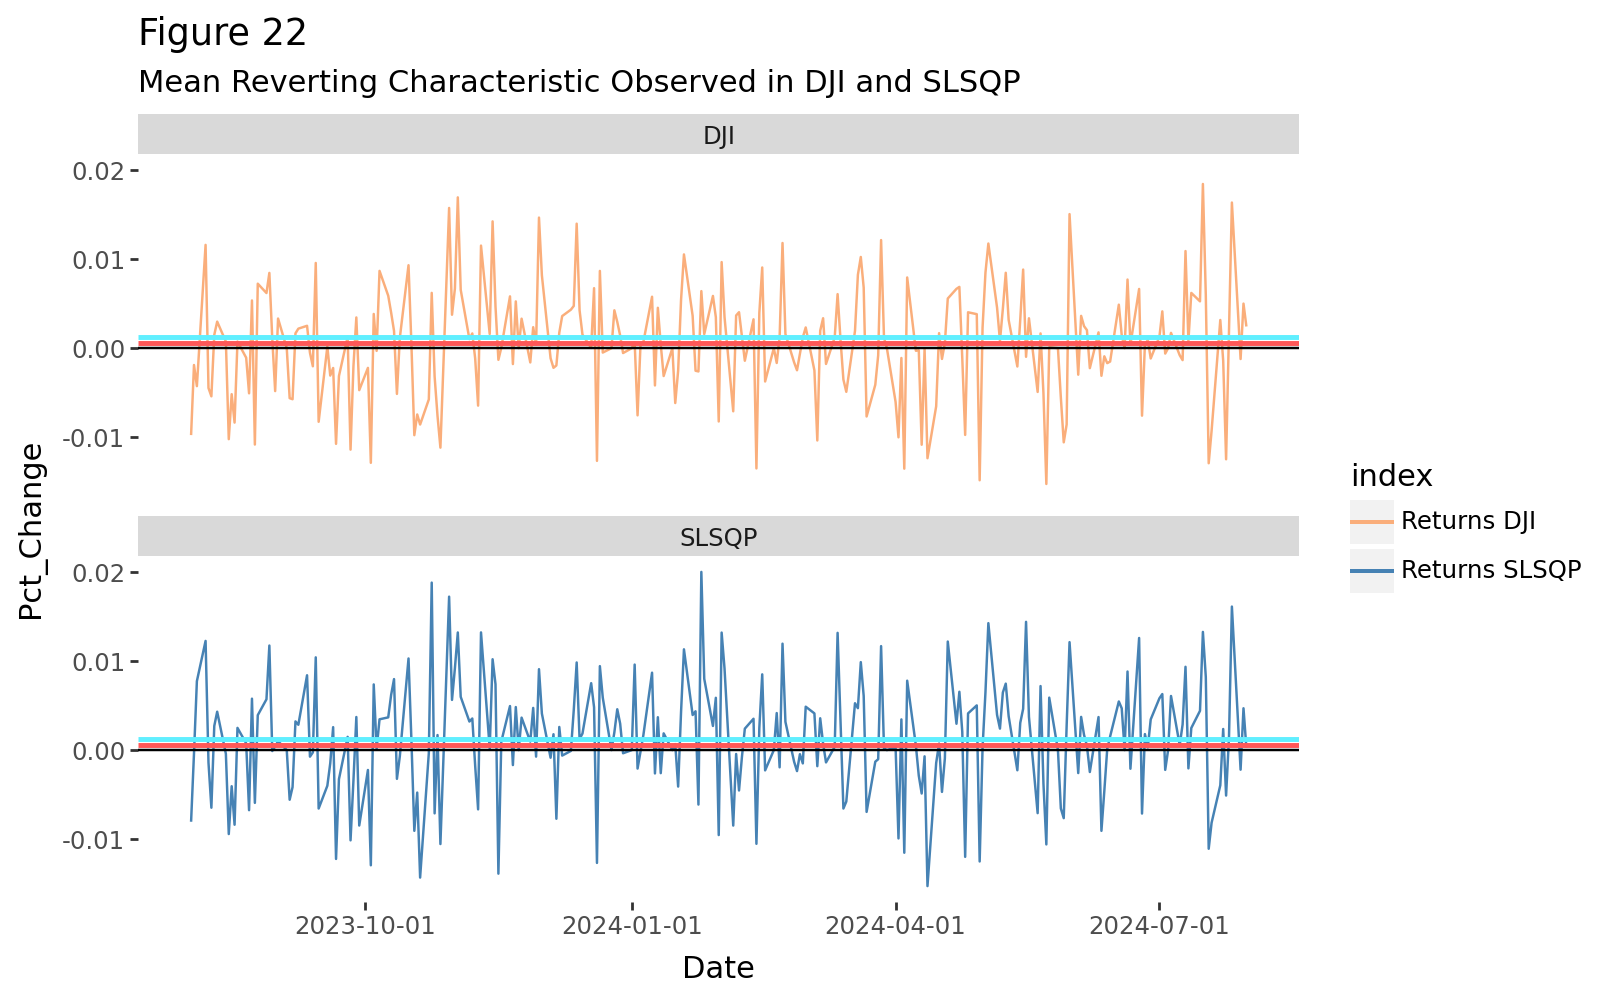

In [57]:
pd.concat([ret_dji_last12months, ret_SLSQP_last12months]) >> ggplot() + geom_line(aes(x='Date',y='Pct_Change',color = 'index')) +\
facet_wrap('~index',nrow=2) +\
      scale_color_manual(
        values={
            'DJI': '#faae7b',
            'SLSQP': 'steelblue'
        },
        labels={
            'DJI': 'Returns DJI',
            'SLSQP': 'Returns SLSQP'
        }        
    ) +\
    theme(panel_background= element_rect(fill='white'), figure_size=(8,5)) +\
    geom_hline(yintercept = exp_ret_DJI, color= '#ff5858',size=1) + geom_hline(yintercept = exp_ret_SLSQP, color= '#60efff',size=1) +\
    geom_hline(yintercept = 0, color= 'black') + labs(title='Figure 22', subtitle='Mean Reverting Characteristic Observed in DJI and SLSQP')

### Test for Stationarity

In [58]:
from statsmodels.tsa.stattools import adfuller

In [59]:
pd.concat([ret_dji_last12months, ret_SLSQP_last12months]) >> rename(index_select = 'index') >>\
group_by(_.index_select) >>summarize(dickey_fuller_test= _['Pct_Change'].agg(adfuller)[1])

,index_select,dickey_fuller_test
0,DJI,3.772399e-27
1,SLSQP,3.445789e-29


## Risk Free Portfolio

Defining Functions

In [60]:
def compounded_rate_return(fn_seriesReturns:pd.Series, fn_init_investment:int = 1_000_000) -> float:
    _1_plus_return=fn_seriesReturns + 1
    _1_plus_return_list=[x for x in _1_plus_return]
    _1_plus_return_list.insert(0,fn_init_investment)
    last_value = [x for x in pd.Series(_1_plus_return_list).cumprod()][-1]
    first_value = fn_init_investment
    return (last_value/first_value) ** (1/len(fn_seriesReturns)) -1   

def last_value_expected(fn_seriesReturns:pd.Series, fn_init_investment:int = 1_000_000) -> float:
    _1_plus_return=fn_seriesReturns + 1
    _1_plus_return_list=[x for x in _1_plus_return]
    _1_plus_return_list.insert(0,fn_init_investment)
    last_value = [x for x in pd.Series(_1_plus_return_list).cumprod()][-1]
    
    return last_value

def Series_dollar_expected_from_returns(fn_seriesReturns:pd.Series, fn_init_investment:int = 1_000_000) -> pd.Series:
    _1_plus_return=fn_seriesReturns + 1
    _1_plus_return_list=[x for x in _1_plus_return]
    _1_plus_return_list.insert(0,fn_init_investment)  
    
    return pd.Series(_1_plus_return_list).cumprod()

def Series_dollar_expected_fromCompoundedReturn(fn_seriesReturns:pd.Series, fn_init_investment:int = 1_000_000)-> pd.Series:
    _fndaily_returns=[x+1 for x in [compounded_rate_return(fn_seriesReturns)] * len(fn_seriesReturns)]
    _fndaily_returns.insert(0,fn_init_investment)
    return pd.Series(_fndaily_returns).cumprod()


Creating Dataframe

In [63]:
index_lastYear_prices=full_hist_prices >> filter(_.index >= '2023-08-01', _.index<'2024-08-01') >> _.index
df_1mm_port_slsqp_risk_and_noRisk=pd.DataFrame({    
    'port_returns_SLSQP_wRisk': Series_dollar_expected_from_returns(ret_SLSQP_last12months.Pct_Change),
    'port_returns_SLSQP_noRisk': Series_dollar_expected_fromCompoundedReturn(ret_SLSQP_last12months.Pct_Change) 
}) #.melt() >> ggplot() + geom_line(aes())
df_1mm_port_slsqp_risk_and_noRisk.index = index_lastYear_prices

### Graph SLSQP vs SLSQP With No Risk

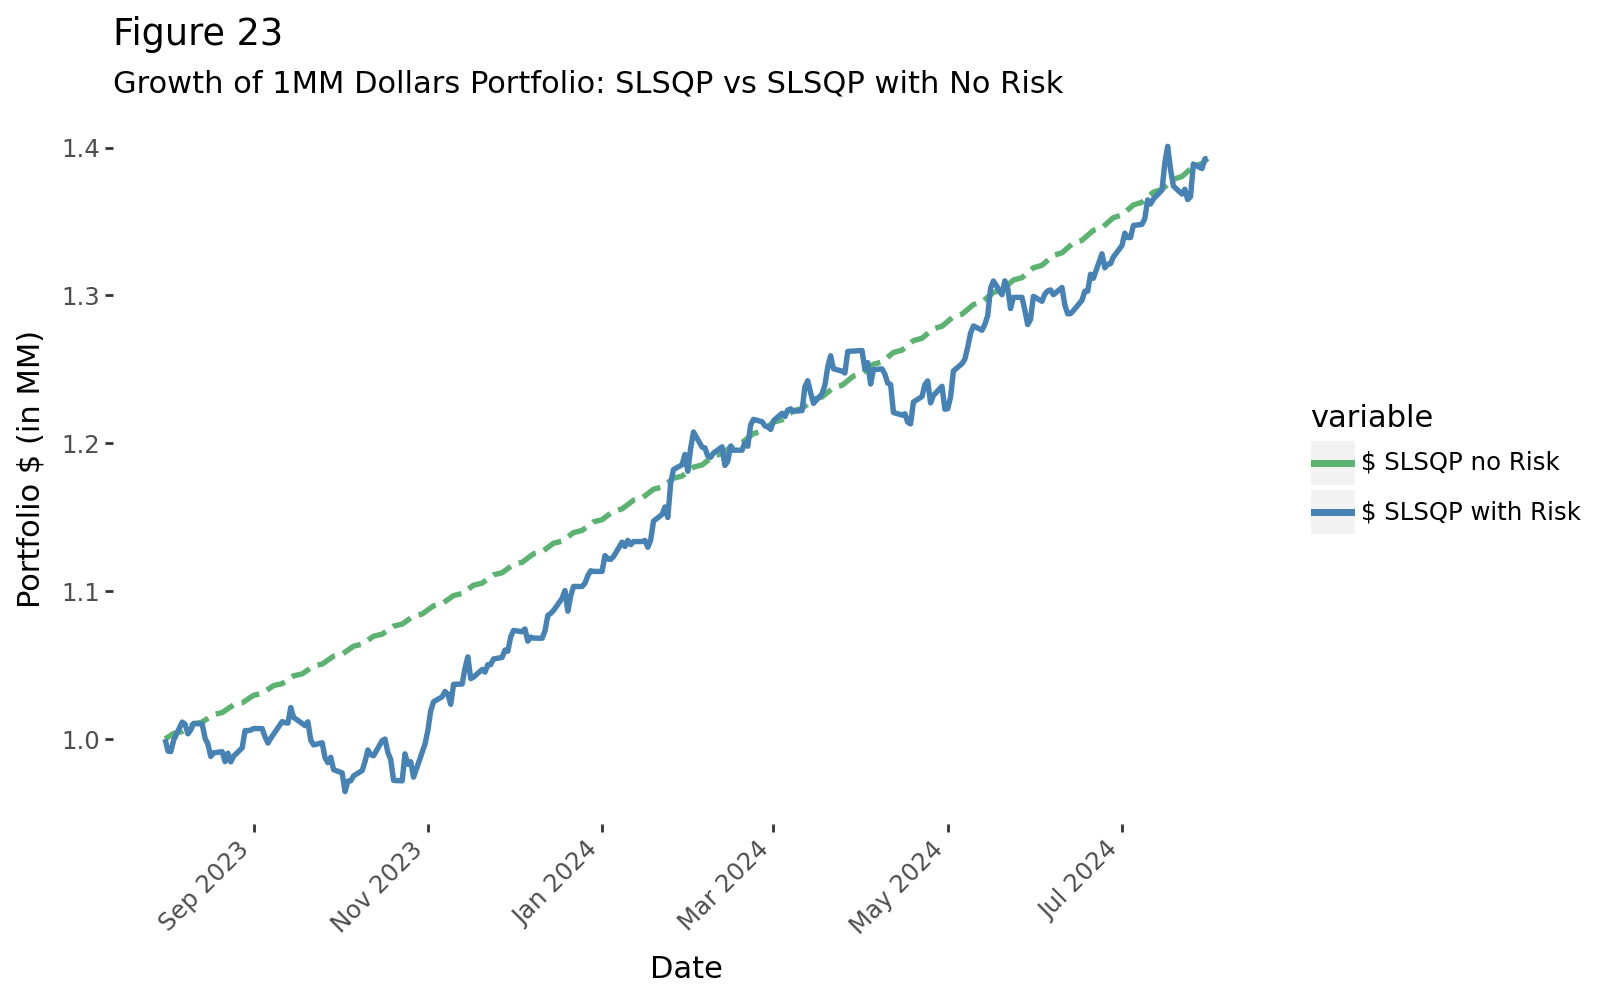

In [66]:
df_1mm_port_slsqp_risk_and_noRisk.reset_index().melt(id_vars='Date') >> mutate(value = _.value/1_000_000
                                                                               ) >>\
ggplot() + geom_line(aes(x='Date',y='value', color='variable', linetype='variable'), size=1.1) + labs(y='Portfolio $ (in MM)')+\
     scale_x_datetime(date_breaks="2 months", date_labels="%b %Y")+ theme(axis_text_x=element_text(angle=45, hjust=1))+\
      scale_color_manual(
        values={
            'port_returns_SLSQP_wRisk': 'steelblue',
            'port_returns_SLSQP_noRisk': '#5cb270'
        },
        labels={
            'port_returns_SLSQP_noRisk': '$ SLSQP no Risk',
            'port_returns_SLSQP_wRisk': '$ SLSQP with Risk'
        }        
    ) +\
      theme(panel_background=element_rect(fill='white'), figure_size=(8,5))+\
      scale_linetype_manual(values={'port_returns_SLSQP_wRisk': 'solid', 'port_returns_SLSQP_noRisk': 'dashed'})+ guides(linetype=False)+\
      labs(title='Figure 23', subtitle='Growth of 1MM Dollars Portfolio: SLSQP vs SLSQP with No Risk')


### Prices beginning of period and after 1 year

In [68]:
df_1mm_port_slsqp_risk_and_noRisk >> filter(_.index.isin(['2023-08-01','2024-07-31']))

,port_returns_SLSQP_wRisk,port_returns_SLSQP_noRisk
Date,,
2023-08-01,1.000000e+06,1.000000e+06
2024-07-31,1.392725e+06,1.392725e+06


### First 65 Days SLSQP was Underperforming 
Price of SLSQP Optimized Portfolio provided no clear indication of performing above the initial investment

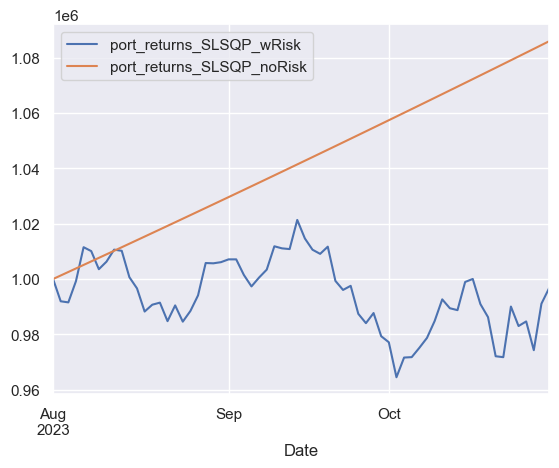

In [76]:
df_1mm_port_slsqp_risk_and_noRisk.iloc[:66,:].plot()
plt.show()